In [18]:
pwd

'/home/jovyan/critical_feature_extraction'

In [21]:
cd critical_feature_extraction/

/home/jovyan/critical_feature_extraction


In [22]:
%run __init__.py
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.metrics import r2_score, mean_squared_error

### Feature Extraction:
1. Check df and clean 
2. KPCA
3. Think of other non-linear dimension reduction tools.

In [23]:
apple = pd.read_csv('data/sandp500/individual_stocks_5yr_TECHNICALS_clean/AAPL_data.csv')

cvs = pd.read_csv('data/sandp500/individual_stocks_5yr_TECHNICALS_clean/CVS_data.csv')

wfc = pd.read_csv('data/sandp500/individual_stocks_5yr_TECHNICALS_clean/WFC_data.csv')

### Clean Data:
1. Download 3 stocks' TI's
2. Check data
3. Drop unnessesary columns
4. concatenate the data

In [24]:
def clean_data(df):
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)
    else:
        pass
    if 'Unnamed: 0.1' in df.columns:    
        df = df.drop('Unnamed: 0.1', axis=1)
    else:
        pass
    if 'Unnamed: 0.1.1' in df.columns:
        df = df.drop('Unnamed: 0.1.1', axis=1)
    else:
        pass
    return df

In [25]:
apple = clean_data(apple)
cvs = clean_data(cvs)
wfc= clean_data(wfc)

In [26]:
wfc = wfc.drop('Date', axis=1)
cvs = cvs.drop('Date', axis=1)

In [27]:
multi_positions = pd.concat([wfc, cvs], axis=1, join='inner')
multi_positions = pd.concat([multi_positions, apple], axis = 1, join='inner')

In [28]:
multi_positions = multi_positions.set_index(pd.to_datetime(multi_positions.Date))
multi_positions = multi_positions.drop('Date', axis=1)
multi_positions = multi_positions.sort_index()

In [29]:
multi_positions = multi_positions.drop('Name', axis=1)

In [30]:
multi_positions.shape

(1187, 139)

### Building Model with KPCA & SVR:
1. Extract X and y values
2. train, test, split
3. Grid Search
    - build pipeline
    - build grid
    - preform gridsearch
    - fit pipe


In [31]:
#define the y's as the current day's trading signal 
y = multi_positions.Target
X = multi_positions.drop('Target', axis=1)

In [32]:
#because this is time-series data we must manually split the data 
X_train = X.iloc[0:900, :]
y_train = y.iloc[0:900]
X_test = X.iloc[900:, :]
y_test = y.iloc[900:]

In [33]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kpca', KernelPCA()),
    ('svr', SVR())
])

In [34]:
kpca_params = {
    'kpca__n_components': np.arange(2, 11, 1),
    'kpca__kernel': ['rbf', 'sigmoid', 'cosine'],
    'kpca__gamma': np.linspace(.1, 1, 10),
    'svr__kernel':['sigmoid', 'rbf'],  
    'svr__C': [0.001, 0.01, 0.1, 1.0, 10.0]
}

In [35]:
pipe_gs = GridSearchCV(pipeline, param_grid= kpca_params, cv=[(slice(None), slice(None))], n_jobs=-1)

In [36]:
pipe_gs.fit(X_train, y_train)

GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
       error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='linear',
     kernel_params=None, max_iter=None, n_components=None, n_jobs=1,
     ran... epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'kpca__n_components': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]), 'kpca__kernel': ['rbf', 'sigmoid', 'cosine'], 'kpca__gamma': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]), 'svr__kernel': ['sigmoid', 'rbf'], 'svr__C': [0.001, 0.01, 0.1, 1.0, 10.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [37]:
y_pred = pipe_gs.predict(X_test)

In [41]:
pipe_gs.score(X_train, y_train)

0.9093901100985583

In [38]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Explained Variance: %.2f' % r2_score(y_test, y_pred))

Mean squared error: 0.11
Explained Variance: -5.20


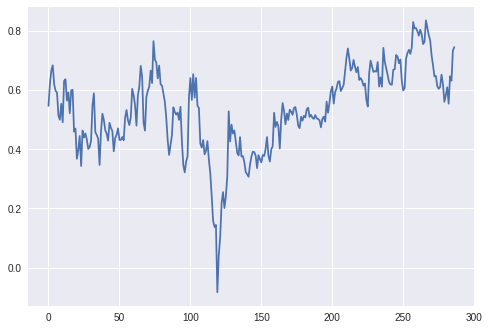

In [39]:
plt.plot(y_pred)
plt.show()

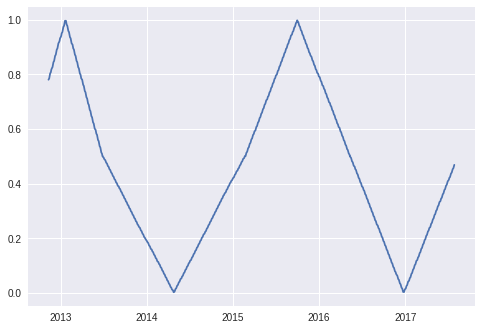

In [40]:
plt.plot(y)
plt.show()